# Hospital San Vicente Fundación
## Prueba técnica
### Por: Carlos José Muñoz Cabrera

A continuación se realiza el proceso de análisis de la base de datos de facturación disponible para realizar la prueba técnica para el puesto de "Investigador de datos".

In [337]:
# Importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import re
import unidecode
import scipy.stats as stats
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV

from src import config 
from src import transform

In [2]:
#Se carga el archivo para hacer un análisis inicial
data_folder = config.DATASET_ROOT_PATH
billing_records_name = config.CSV_NAME
billing_records = pd.read_excel(f"{data_folder}/{billing_records_name}")
#Observamos las primeras filas para dar un primer vistazo al contenido del dataframe. 
print(f'Tamaño de la BD: {billing_records.shape}')
billing_records.head(20)

Tamaño de la BD: (382436, 12)


,Código Episodio,Valor neto,Mon.,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Causa Externa,Pais de Nacimiento
0,4230800,238650.0,COP,2022-01-01,"SEGUROS DE VIDA SURAMERICANA, POLIZA JUVENIL.A...",Ambulatorio,530101,M,RETIRO,14 A,Otro accidente fortuito,colombiana
1,4241800,29735371.5,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,GUARNE,85 A,Enfermedad General,colombiana
2,4241800,19312.5,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,GUARNE,85 A,Enfermedad General,colombiana
3,4254640,17203698.0,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,RIONEGRO,41 A,Enfermedad General,colombiana
4,4254640,43656.0,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,RIONEGRO,41 A,Enfermedad General,colombiana
5,4256037,28597236.0,COP,2022-01-01,SALUD TOTAL EPS-S S.A,Hospitalizado,530718,M,MEDELLIN,53 A,Accidente de tránsito,colombiana
6,4258159,14385303.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,GUARNE,28 A,Enfermedad General,colombiana
7,4258692,17856432.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,MARINILLA,84 A,Enfermedad General,colombiana
8,4258692,446739.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,MARINILLA,84 A,Enfermedad General,colombiana
9,4259044,8324949.0,COP,2022-01-01,EPS SURA,Hospitalizado,530718,M,RIONEGRO,24 A,Enfermedad General,colombiana


In [3]:
#Vamos a verificar el contenido del dataframe.
billing_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382436 entries, 0 to 382435
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Código Episodio            382436 non-null  int64         
 1   Valor neto                 382436 non-null  float64       
 2   Mon.                       382436 non-null  object        
 3   Creado el                  382436 non-null  datetime64[ns]
 4   Aseguradora                382436 non-null  object        
 5   Clase episodio             382436 non-null  object        
 6   Centro de Responsabilidad  382436 non-null  int64         
 7   Género                     382436 non-null  object        
 8   Población                  382436 non-null  object        
 9   Edad                       382157 non-null  object        
 10  Causa Externa              112259 non-null  object        
 11  Pais de Nacimiento         382272 non-null  object  

In [4]:
billing_records.describe()

,Código Episodio,Valor neto,Creado el,Centro de Responsabilidad
count,3.824360e+05,3.824360e+05,382436,382436.000000
mean,4.715839e+06,2.065733e+06,2023-02-26 14:25:32.491710720,530400.723452
min,2.175915e+06,-2.812500e+05,2022-01-01 00:00:00,530101.000000
25%,4.497527e+06,5.250000e+04,2022-08-05 00:00:00,530201.000000
50%,4.726374e+06,9.750000e+04,2023-03-09 00:00:00,530301.000000
75%,4.941668e+06,3.323265e+05,2023-09-20 00:00:00,530801.000000
max,5.148909e+06,1.457064e+09,2024-03-31 00:00:00,530815.000000
std,2.625891e+05,1.341694e+07,NaN,281.627457


Se puede observar que las columnas Edad, Causa externa y país de nacimiento no están completas. En este sentido vamos a verificar cómo tratar estos valores nulos según sea el caso.

In [5]:
#Verificamos los valores que puede tomar edad
billing_records['Edad'].value_counts()

Edad
61 A    8522
62 A    8483
69 A    8100
72 A    7558
60 A    7546
        ... 
105        2
27 D       2
28 D       2
6 D        1
107        1
Name: count, Length: 154, dtype: int64

Se puede ver que en la columna edad existen diferentes formatos como 12 A, 12 D, o 4:00:00 AM. Dado que no tenemos un contexto claro al respecto, se procede a convertir estos valores a enteros, tomandolos como errores de entrada y dejando las edades en un solo formato. Sin embargo, es necesario investigar la razón de los diferentes formatos y poder aplicar un tratamiento más adecuado.

In [6]:
billing_records['Edad'] = billing_records['Edad'].apply(transform.convert_to_number)
billing_records.head(20)

,Código Episodio,Valor neto,Mon.,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Causa Externa,Pais de Nacimiento
0,4230800,238650.0,COP,2022-01-01,"SEGUROS DE VIDA SURAMERICANA, POLIZA JUVENIL.A...",Ambulatorio,530101,M,RETIRO,14.0,Otro accidente fortuito,colombiana
1,4241800,29735371.5,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,GUARNE,85.0,Enfermedad General,colombiana
2,4241800,19312.5,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,GUARNE,85.0,Enfermedad General,colombiana
3,4254640,17203698.0,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,RIONEGRO,41.0,Enfermedad General,colombiana
4,4254640,43656.0,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,RIONEGRO,41.0,Enfermedad General,colombiana
5,4256037,28597236.0,COP,2022-01-01,SALUD TOTAL EPS-S S.A,Hospitalizado,530718,M,MEDELLIN,53.0,Accidente de tránsito,colombiana
6,4258159,14385303.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,GUARNE,28.0,Enfermedad General,colombiana
7,4258692,17856432.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,MARINILLA,84.0,Enfermedad General,colombiana
8,4258692,446739.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,MARINILLA,84.0,Enfermedad General,colombiana
9,4259044,8324949.0,COP,2022-01-01,EPS SURA,Hospitalizado,530718,M,RIONEGRO,24.0,Enfermedad General,colombiana


El proceso pensado para completar los datos nulos faltantes de la edad es usar la media agrupada por género y aseguradoras. Esto con el fin de aproximarse lo más posible al ajuste de edad sin introducir una varianza en los datos. Usar simplemente la medía podría ser erroneo dado que la distribución población de cada aseguradora sería diferente. 

In [7]:
mean_age_by_group = billing_records.groupby(['Género', 'Aseguradora'])['Edad'].transform(lambda x: np.floor(x.mean()))
billing_records['Edad'] = billing_records['Edad'].fillna(mean_age_by_group)

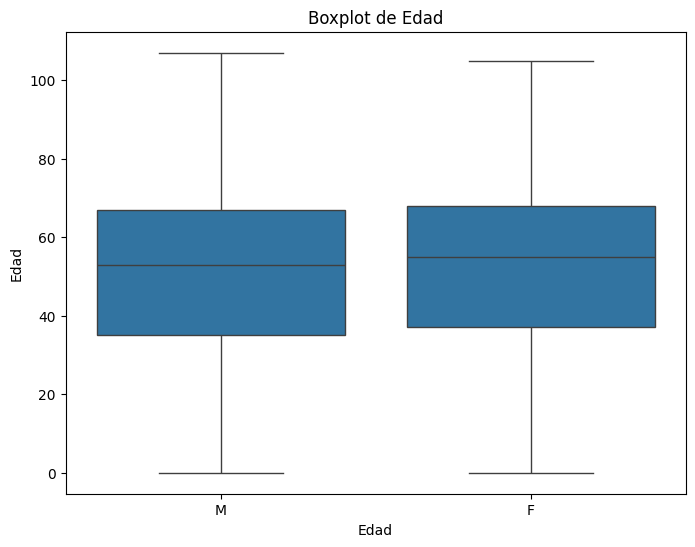

In [8]:
plt.figure(figsize=(8, 6))

sns.boxplot(data=billing_records, x='Género', y='Edad')

plt.title('Boxplot de Edad')
plt.xlabel('Edad')
plt.show()

En la gráfica podemos ver la distribución de edades por género y vemos un comportamiento similar para cada género. Por otro lado, existen edades que estan por fuera de los valores más comunes pero que no indican un valor atípico que deba tratarse de alguna manera en específico. De esta manera, podemos decir que se ha tratado la columna "Edad" en sus valores nulos y ahora vamos a verificar la columna "Causa Externa" a la cual le hacen falta muchos valores.


La columna "Causa Externa" es una columna de entrada str por lo que lo primero que se apica es una limpieza de esas entradas, de esta manera podemos estandarizar los datos un poco

In [9]:
billing_records['Causa Externa'] = billing_records['Causa Externa'].apply(transform.clean_text)

Causa Externa
Desconocido                                 270177
enfermedad general                           95426
otro accidente fortuito                       7947
accidente de transito                         5955
accidente de trabajo                          1607
otra                                           416
accidente rabico                               228
enfermedad profesional                         153
agresion lucha o violencia                      91
agresion arma de fuego                          87
agresion arma corto punzante                    72
lesion autoinflingida                           71
agresion violacion                              34
agresion arma contundente                       31
otro accidente mordedura de animal              24
otro accidente intoxicacion ingesta             22
otro accidente cuerpo extrano                   16
otro accidente quemadura llama                  14
agresion otro medio de ataque                   14
otro accidente qu

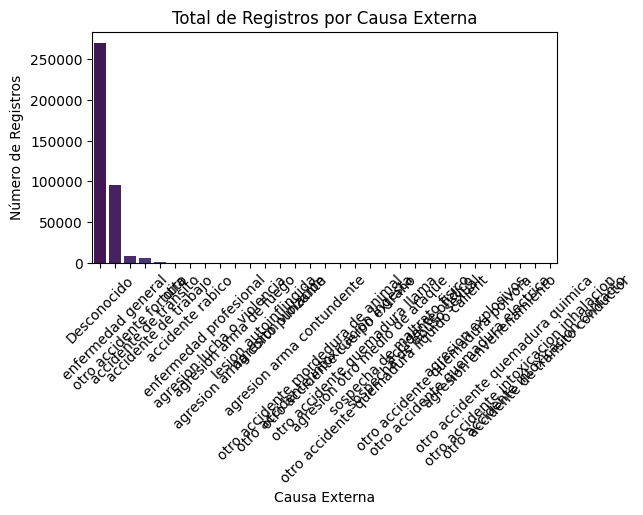

In [10]:
billing_records['Causa Externa'] = billing_records['Causa Externa'].fillna('Desconocido')
print(billing_records['Causa Externa'].value_counts())

causa_counts = billing_records['Causa Externa'].value_counts().reset_index()
causa_counts.columns = ['Causa Externa', 'Número de Registros']

# Crear el gráfico
plt.figure(figsize=(6, 3))
sns.barplot(data=causa_counts, x='Causa Externa', y='Número de Registros', hue='Causa Externa', palette='viridis', legend=False)
plt.title('Total de Registros por Causa Externa')
plt.xlabel('Causa Externa')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
plt.show()

La columna "Causa Externa" podría indicar patrones asociados que permitan predecir el valor neto pero dado que más de la mitad de los registros es nulo, no se podrían incluir en la cateegoría más frecuente o incluso en la categoría otra puesto que implicaría un cambio drástico en la distribución de los registros. En este sentido, se procede a eliminar dicha columna que podría introducir un sesgo al modelo predictivo.

In [11]:
billing_records = billing_records.drop(columns=['Causa Externa'])

Ahora vamos a verificar la columna "Pais de Nacimiento".

In [12]:
billing_records['Pais de Nacimiento'] = billing_records['Pais de Nacimiento'].apply(transform.clean_text)
billing_records['Pais de Nacimiento'].value_counts()

Pais de Nacimiento
colombiana        379515
estadounidense      1182
venezolana           315
alemana              131
boliviana            129
italiana             117
canadiense            93
guatemalteca          84
britanica             70
argentina             50
espanola              48
de eau                48
mexicana              45
ecuatoriana           39
peruana               39
neerlandesa           29
chilena               28
cubana                26
costarricense         26
belga                 25
portuguesa            24
francesa              23
brasilena             21
sueca                 14
panamena              12
israeli               12
arubena               10
ruso                   8
nicaraguense           8
libanesa               8
armenia                7
noruega                7
lituana                6
jamaicana              6
serbmonten             6
india                  6
dominicana             5
china                  5
surinamesa             5
belice

Para verificar si esta variable podría insidir en la determinación del valor neto, procedemos a verificarla visualmente y a realizar una prueba de homogeneidad de varianzas (prueba de Levene) y Anova. Esto nos permite distinguir si existen diferencias significativas en el valor neto entre cada grupo de países.

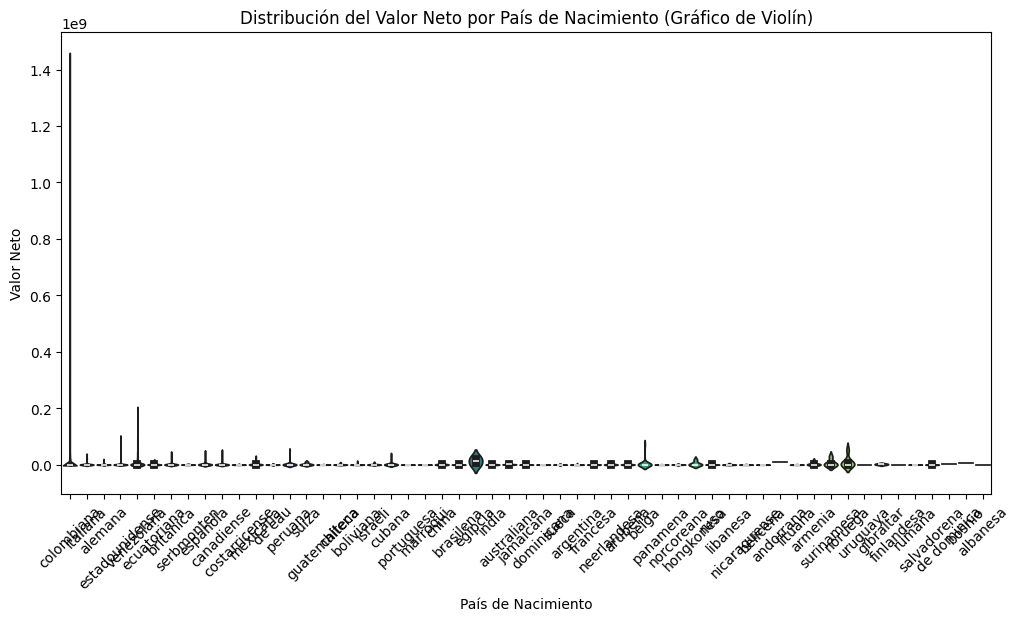

In [13]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Pais de Nacimiento', y='Valor neto', hue='Pais de Nacimiento',data=billing_records, palette='viridis', legend=False)
plt.title('Distribución del Valor Neto por País de Nacimiento (Gráfico de Violín)')
plt.xlabel('País de Nacimiento')
plt.ylabel('Valor Neto')
plt.xticks(rotation=45)
plt.show()

In [14]:
grupos = [group['Valor neto'].values for name, group in billing_records.groupby('Pais de Nacimiento')]
stat, p_value = levene(*grupos)
print(f'Estadístico de Levene: {stat:.3f}, Valor p: {p_value:.3f}')

Estadístico de Levene: 0.452, Valor p: 1.000


In [15]:
anova_results = stats.f_oneway(*[group['Valor neto'].values for name, group in billing_records.groupby('Pais de Nacimiento')])
print('Estadístico F:', anova_results.statistic)
print('Valor p:', anova_results.pvalue)

if anova_results.pvalue < 0.05:
    print("Hay diferencias significativas entre al menos dos grupos de países.")
else:
    print("No hay diferencias significativas entre los grupos de países.")

Estadístico F: 0.4598941423787961
Valor p: 0.9997733529919197
No hay diferencias significativas entre los grupos de países.


Como se observa, los datos presentan una homogeneidad de varianza, según los resultados de la prueba de Levene, por lo que al aplicar Anova podemos establecer que no existen diferencias entre cada país respecto al valor neto. Además, se pueden verificar estos resultados en el gráfico de distribución por país, donde vemos que la distribución es similar entre cada uno. Esto nos permite concluir que no es necesaria la columna de país de nacimiento en la predicción de valor neto.


In [16]:
billing_records = billing_records.drop(columns=['Pais de Nacimiento'])

Ya hemos terminado con el tratamiento de valores nulos en aquellas columnas que los presentaban. Ahora vamos a verificar aquellas columnas que son importantes para la predicción del valor neto.


In [17]:
billing_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382436 entries, 0 to 382435
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Código Episodio            382436 non-null  int64         
 1   Valor neto                 382436 non-null  float64       
 2   Mon.                       382436 non-null  object        
 3   Creado el                  382436 non-null  datetime64[ns]
 4   Aseguradora                382436 non-null  object        
 5   Clase episodio             382436 non-null  object        
 6   Centro de Responsabilidad  382436 non-null  int64         
 7   Género                     382436 non-null  object        
 8   Población                  382436 non-null  object        
 9   Edad                       382436 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 29.2+ MB


Vamos a comenzar con Código Episodio, vamos a verificar cuantas categorías únicas existen dentro de esta columna, teniendo en cuenta que el código episodio es el código de cada paciente ingresado al hospital

In [18]:
print(f'La cantidad de códigos existentes es: {billing_records['Código Episodio'].nunique()}')
print(f'La distribución estadística es:')
billing_records['Código Episodio'].describe()

La cantidad de códigos existentes es: 264159
La distribución estadística es:


count    3.824360e+05
mean     4.715839e+06
std      2.625891e+05
min      2.175915e+06
25%      4.497527e+06
50%      4.726374e+06
75%      4.941668e+06
max      5.148909e+06
Name: Código Episodio, dtype: float64

In [19]:
correlation = billing_records[['Código Episodio', 'Valor neto']].corr()
print(correlation)

                 Código Episodio  Valor neto
Código Episodio         1.000000    0.006857
Valor neto              0.006857    1.000000


Teniendo en cuenta que el código episodio es el código que se asiga a cada paciente al ingreso al hospital, este código es un indicador que no aporta mayor información puesto que es único y no permite generalización dentro del modelo predictivo. Además, la correlación dio un valor bastante bajo con respecto al valor neto, por lo que podemos concluir en que no es una variable que aporta información relevante e importante al modelo preditivo que se busca realizar.

In [20]:
billing_records = billing_records.drop(columns=['Código Episodio'])

Ahora vamos a verificar Valor neto de la mano de la columna Mon. La variable objetivo de el modelo predictivo que se busca desarrollar es valor neto; este valor puede venir en las diferentes monedas que existen a nivel mundial. 

In [21]:
billing_records['Mon.'].value_counts()

Mon.
COP    382379
USD        57
Name: count, dtype: int64

In [22]:
billing_records['Valor neto'].describe()

count    3.824360e+05
mean     2.065733e+06
std      1.341694e+07
min     -2.812500e+05
25%      5.250000e+04
50%      9.750000e+04
75%      3.323265e+05
max      1.457064e+09
Name: Valor neto, dtype: float64

In [23]:
billing_records[billing_records['Valor neto'] < 0]

,Valor neto,Mon.,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad
74559,-20700.0,COP,2022-06-15,EMPRESAS PUBLICAS,Ambulatorio,530201,M,MEDELLIN,64.0
85037,-281182.5,COP,2022-07-12,EPS SURA,Ambulatorio,530301,F,RIONEGRO,57.0
85059,-100500.0,COP,2022-07-12,EPS SURA,Ambulatorio,530201,F,RIONEGRO,57.0
347489,-218850.0,COP,2024-01-23,SEGUROS DEL ESTADO S.A. - SOAT,Ambulatorio,530101,M,MARINILLA,49.0
349500,-96750.0,COP,2024-01-26,ASEGURADORA SOLIDARIA DE COLOMB ENTIDAD COOPER...,Ambulatorio,530301,M,CARMEN DE VIBORAL,16.0
350407,-281250.0,COP,2024-01-29,SEGUROS DEL ESTADO S.A. - SOAT,Ambulatorio,530201,M,MARINILLA,27.0


Como se puede observar, existen registros negativos en la columna de valor neto y todos en moneda colombiana (COP). Lo ideal es investigar un poco más a qué se deben; puede ser porque son ajustes realizados. En este caso, vamos a eliminar estos registros, puesto que representan menos del 0.01 % de los datos en el dataset, por lo que no van a afectar en mayor medida al modelo. 


In [24]:
billing_records = billing_records[billing_records['Valor neto']>=0]

In [25]:
TRM = 4000

# Convertir los valores de "Valor neto" de USD a COP
billing_records.loc[billing_records['Mon.'] == 'USD', 'Valor neto'] *= TRM
billing_records[billing_records['Mon.']=='USD']

,Valor neto,Mon.,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad
541,21142380.0,USD,2022-01-03,PARTICULARES,Hospitalizado,530718,M,MEDELLIN,91.0
752,1465380.0,USD,2022-01-03,PARTICULARES,Ambulatorio,530809,M,MEDELLIN,38.0
2467,20941260.0,USD,2022-01-06,PARTICULARES,Hospitalizado,530718,M,RIONEGRO,35.0
3092,8183400.0,USD,2022-01-07,PARTICULARES,Ambulatorio,530809,M,RIONEGRO,35.0
3100,5466720.0,USD,2022-01-07,PARTICULARES,Hospitalizado,530718,M,MEDELLIN,7.0
6981,2304780.0,USD,2022-01-17,PARTICULARES,Hospitalizado,530718,M,MEDELLIN,33.0
13519,10341660.0,USD,2022-01-31,PARTICULARES,Hospitalizado,530718,M,MEDELLIN,69.0
15612,100440.0,USD,2022-02-03,PARTICULARES,Ambulatorio,530101,F,MEDELLIN,38.0
23678,2083320.0,USD,2022-02-22,UNIVERSAL ASSISTANCE,Ambulatorio,530101,F,RIONEGRO,49.0
24603,934260.0,USD,2022-02-23,PARTICULARES,Ambulatorio,530801,M,RIONEGRO,4.0


In [26]:
billing_records[billing_records['Mon.']=='USD'].describe()

,Valor neto,Creado el,Centro de Responsabilidad,Edad
count,5.700000e+01,57,57.000000,57.000000
mean,1.712024e+07,2022-11-29 07:09:28.421052672,530603.982456,48.473684
min,1.004400e+05,2022-01-03 00:00:00,530101.000000,4.000000
25%,2.304780e+06,2022-04-11 00:00:00,530718.000000,35.000000
50%,5.466720e+06,2022-10-15 00:00:00,530718.000000,49.000000
75%,2.094126e+07,2023-07-02 00:00:00,530718.000000,66.000000
max,1.349980e+08,2024-03-04 00:00:00,530809.000000,91.000000
std,2.631923e+07,NaN,238.277561,21.122183


Se realizó una conversión de datos a COP de aquellos que se encuentran en USD, con el fin de trabajar con lás mismas monedas. 

In [27]:
billing_records['Valor neto'].describe()

count    3.824300e+05
mean     2.068319e+06
std      1.342205e+07
min      0.000000e+00
25%      5.250000e+04
50%      9.750000e+04
75%      3.323265e+05
max      1.457064e+09
Name: Valor neto, dtype: float64

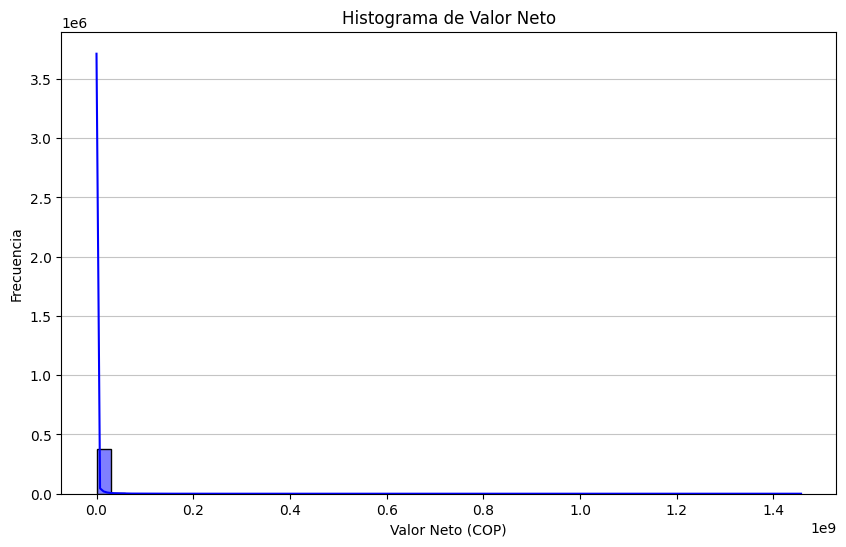

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(billing_records['Valor neto'], bins=50, color='blue', kde=True)  # kde=True añade una curva de densidad
plt.title('Histograma de Valor Neto')
plt.xlabel('Valor Neto (COP)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [29]:
billing_records[billing_records['Valor neto']>1000000000]

,Valor neto,Mon.,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad
249719,1.254684e+09,COP,2023-07-07,SALUD TOTAL E.P.S.,Hospitalizado,530718,F,CARTAGENA,38.0
336805,1.457064e+09,COP,2024-01-22,SALUD TOTAL E.P.S.,Hospitalizado,530718,F,BARRANQUILLA,35.0


In [30]:
Q1 = billing_records['Valor neto'].quantile(0.25)
Q3 = billing_records['Valor neto'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 3 * IQR
upper_bound

np.float64(1171806.0)

In [31]:
outliers = billing_records[(billing_records['Valor neto'] > upper_bound)]
outliers

,Valor neto,Mon.,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad
1,29735371.5,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,GUARNE,85.0
3,17203698.0,COP,2022-01-01,EPS SURA,Hospitalizado,530718,F,RIONEGRO,41.0
5,28597236.0,COP,2022-01-01,SALUD TOTAL EPS-S S.A,Hospitalizado,530718,M,MEDELLIN,53.0
6,14385303.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,GUARNE,28.0
7,17856432.0,COP,2022-01-01,NUEVA EMPRESA PROMOTORA DE SALU S.A.,Hospitalizado,530718,M,MARINILLA,84.0
...,...,...,...,...,...,...,...,...,...
382358,1383244.5,COP,2024-03-30,"SEGUROS DE VIDA SURAMERICANA, POLIZA GLOBAL O ...",Ambulatorio,530809,M,MEDELLIN,8.0
382359,2669368.5,COP,2024-03-31,"SEGUROS SURA SALUD, POLIZA EVOLUCIONA",Ambulatorio,530809,M,ENVIGADO,27.0
382370,2357898.0,COP,2024-03-31,"SEGUROS SURA SALUD, POLIZA EVOLUCIONA",Ambulatorio,530809,F,RETIRO,41.0
382376,1415092.5,COP,2024-03-31,COOMEVA MEDICINA PREPAGADA S.A.,Ambulatorio,530101,M,RIONEGRO,69.0


En el análisis que se acaba de realizar, se intentó buscar valores atípicos presentes en el valor neto. En el histograma se puede ver cómo la mayoría de valores son bajos, lo cuál indica la distribución con un sesgo a la derecha. Sin embargo, se puede ver que aún encontrando el rango intercuartilico y encontrando valores por arriba de hasta 3 veces ese rango existen una cantidad significativa de valores por lo que no podemos tomar estos valores como atípicos y procesarlos como tal.

Ahora vamos a analizar la columna de "Creado el". Inicialmente vamos a organizar el dataframe en fechas, puesto que nuestro objetivo es poder determinar la predicción del valor neto por semana.

In [32]:
billing_records = billing_records.sort_values(by='Creado el').reset_index(drop=True)

In [33]:
billing_records['Creado el'].describe()

count                           382430
mean     2023-02-26 14:24:28.240462336
min                2022-01-01 00:00:00
25%                2022-08-05 00:00:00
50%                2023-03-09 00:00:00
75%                2023-09-20 00:00:00
max                2024-03-31 00:00:00
Name: Creado el, dtype: object

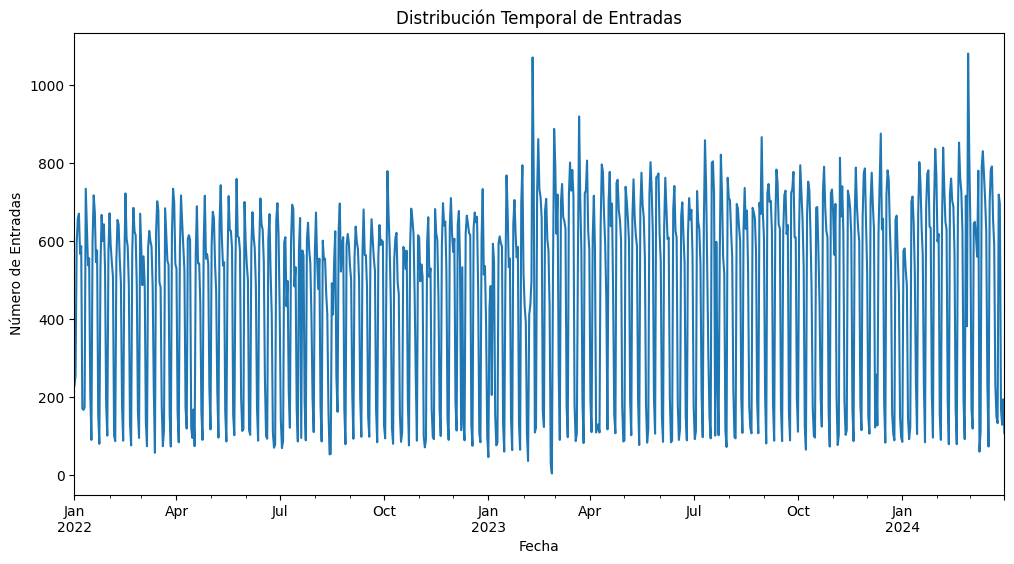

In [34]:
daily_counts = billing_records['Creado el'].value_counts().sort_index()

# Graficar la distribución
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.xlabel('Fecha')
plt.ylabel('Número de Entradas')
plt.title('Distribución Temporal de Entradas')
plt.show()

En esta columna no vamos a hacer más por ahora, todos los datos parecen estar bien dentro de los rangos comunes desde enero de 2022 hasta marzo de 2024. Posteriormente se hará un analisis temporal más riguroso.

Ahora vamos a verificar la columna Aseguradora.

In [35]:
billing_records['Aseguradora'] = billing_records['Aseguradora'].apply(transform.normalize_insurer)
billing_records['Aseguradora'] = billing_records['Aseguradora'].apply(transform.clean_text)
billing_records['Aseguradora'] = billing_records['Aseguradora'].replace(r'\b(sa|sas)\b', '', regex=True)
billing_records['Aseguradora'] = billing_records['Aseguradora'].replace(r'\b(s|a)\b', '', regex=True)
billing_records['Aseguradora'] = billing_records['Aseguradora'].replace(r'\b(eps|epss)\b', '', regex=True)
billing_records['Aseguradora'] = billing_records['Aseguradora'].apply(transform.clean_text)
billing_records.head()

,Valor neto,Mon.,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad
0,238650.0,COP,2022-01-01,seguros de vida suramericana poliza juvenilaccid,Ambulatorio,530101,M,RETIRO,14.0
1,142500.0,COP,2022-01-01,particulares,Ambulatorio,530101,M,BOGOTA D.C.,51.0
2,142500.0,COP,2022-01-01,particulares,Ambulatorio,530101,M,RIONEGRO,41.0
3,142500.0,COP,2022-01-01,particulares,Ambulatorio,530101,M,MEDELLIN,31.0
4,142500.0,COP,2022-01-01,particulares,Ambulatorio,530101,M,RIONEGRO,38.0


In [36]:
billing_records['Aseguradora'].value_counts()

Aseguradora
particulares                                         128398
seguros de vida suramericana polizas global o cla     65842
nueva empresa promotora de salu                       40829
sura                                                  36577
coomeva medicina prepagada                            23327
                                                      ...  
fundacion colombiana de cancero clinica vida              1
mallamas                                                  1
emssanar entidad promotora de                             1
comfenalco valle                                          1
centro de excelencia medica del                           1
Name: count, Length: 181, dtype: int64

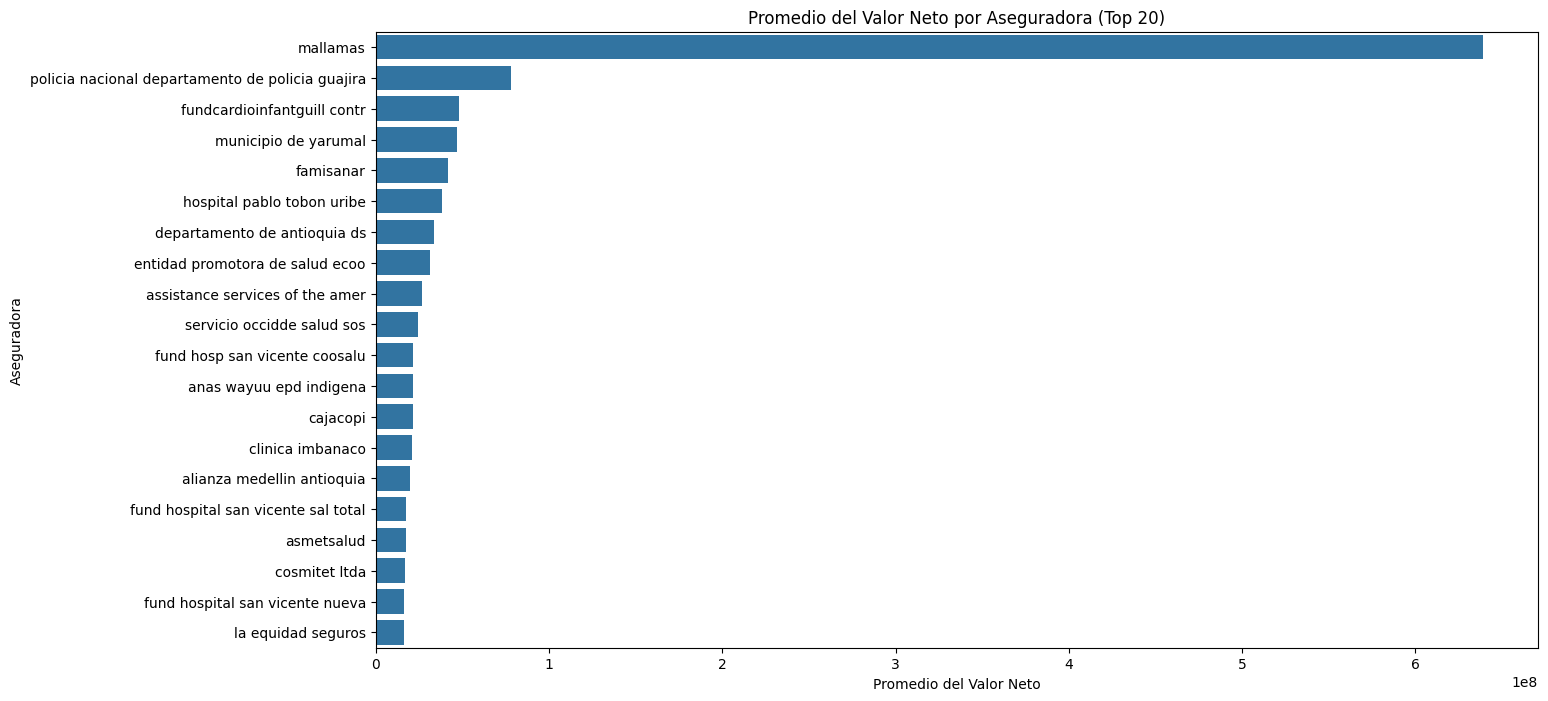

In [37]:
avg_value = billing_records.groupby('Aseguradora')['Valor neto'].mean().reset_index()

avg_value = avg_value.sort_values(by='Valor neto', ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x='Valor neto', y='Aseguradora', data=avg_value.head(20))
plt.title('Promedio del Valor Neto por Aseguradora (Top 20)')
plt.xlabel('Promedio del Valor Neto')
plt.ylabel('Aseguradora')
plt.show()

Como se puede ver en los gráficos, existen aseguradoras que pueden tener un promedio de valor neto bastante elevado, aunque su frecuencia de aparición sea baja. En ese sentido, se puede pensar que la aseguradora tenga una correlación directa con el valor neto, debido a diferentes razones como diferencias en tarifas.

Ahora vamos a verificar la columna clase episodio.

In [38]:
billing_records['Clase episodio'] = billing_records['Clase episodio'].apply(transform.clean_text)
billing_records['Clase episodio'].value_counts()

Clase episodio
ambulatorio      351759
hospitalizado     30671
Name: count, dtype: int64

In [39]:
resultado = billing_records.groupby('Clase episodio')['Valor neto'].agg(['mean', 'median'])

# Muestra el resultado
print(resultado)

                        mean     median
Clase episodio                         
ambulatorio     5.579587e+05    87750.0
hospitalizado   1.939031e+07  5945028.0


In [40]:
ambulatorio = billing_records[billing_records['Clase episodio'] == 'ambulatorio']['Valor neto']
hospitalizado = billing_records[billing_records['Clase episodio'] == 'hospitalizado']['Valor neto']

# Prueba de Mann-Whitney U
stat, p_value = mannwhitneyu(ambulatorio, hospitalizado, alternative='two-sided')
print(f'Estadístico de la prueba Mann-Whitney U: {stat}, p-valor: {p_value}')

Estadístico de la prueba Mann-Whitney U: 791630474.5, p-valor: 0.0


En este caso, se puede observar una clara diferencia entre media y mediana de cada clase en la columna de clase episodio. Además, se aplica la prueba de Mann-Whitney que tiene un valor p bajo, por lo que podemos decir que esta variable tiene una incidencia clara en la determinación de valor neto.

Ahora vamos a verificar el centro responsabilidad

In [41]:
billing_records['Centro de Responsabilidad'].value_counts()

Centro de Responsabilidad
530201    91553
530101    80303
530301    59860
530809    42551
530801    30945
530718    27434
530401    25858
530812    19304
530815     4622
Name: count, dtype: int64

In [42]:
resultado = billing_records.groupby('Centro de Responsabilidad')['Valor neto'].agg(['mean', 'median'])

# Muestra el resultado
print(resultado)

                                   mean     median
Centro de Responsabilidad                         
530101                     9.648091e+05   142500.0
530201                     2.879980e+05    68550.0
530301                     6.766964e+05    82500.0
530401                     8.775283e+05    99450.0
530718                     1.997443e+07  6364257.0
530801                     3.227612e+05    80100.0
530809                     6.444541e+05    63900.0
530812                     2.850772e+05    61650.0
530815                     7.151288e+06   545058.0


Al igual que el análisis anterior, se observa una media y mediana bastante diferente entre cada uno de los centros de responsabilidad, por lo que se puede decir que influye directamente en la predicción del valor neto, pues están correlacionados.

Vamos con la columna de genero

In [43]:
billing_records['Género'].value_counts()

Género
F    204694
M    177736
Name: count, dtype: int64

In [44]:
resultado = billing_records.groupby('Género')['Valor neto'].agg(['mean', 'median'])

# Muestra el resultado
print(resultado)

                mean    median
Género                        
F       1.713391e+06   90600.0
M       2.477081e+06  101250.0


In [45]:
mujeres = billing_records[billing_records['Género'] == 'F']['Valor neto']
hombres = billing_records[billing_records['Género'] == 'M']['Valor neto']

# Prueba de Mann-Whitney U
stat, p_value = mannwhitneyu(mujeres, hombres, alternative='two-sided')
print(f'Estadístico de la prueba Mann-Whitney U: {stat}, p-valor: {p_value}')

Estadístico de la prueba Mann-Whitney U: 17390467424.0, p-valor: 3.712564520794678e-122


Como se observa, tanto en la prueba como en las diferencias de media y mediana, se puede concluir que el género influye directamente en el valor neto debido a que se observan grandes diferencias entre los grupos; de esta manera es una variable útil.

Vamos a seguir con población.

In [46]:
billing_records['Población'].value_counts()

Población
RIONEGRO      136347
MEDELLIN       45710
RETIRO         37335
GUARNE         30476
LA CEJA        26572
               ...  
ROVIRA             1
BOGOTA             1
BAGADO             1
BAGRE              1
valparaiso         1
Name: count, Length: 467, dtype: int64

In [47]:
billing_records['Población'] = billing_records['Población'].apply(transform.clean_text)
billing_records['Población'] = billing_records['Población'].replace(r'\b(dc)\b', '', regex=True)
billing_records['Población'] = billing_records['Población'].replace(r'\b(d|c)\b', '', regex=True)
billing_records['Población'] = billing_records['Población'].replace(r'\b(el|la)\b', '', regex=True)
billing_records['Población'] = billing_records['Población'].apply(transform.clean_text)

In [48]:
billing_records['Población'] = billing_records['Población'].apply(transform.normalize_city)

In [49]:
billing_records = billing_records.drop(billing_records[billing_records['Población'] == 5615].index)

In [50]:
len(billing_records['Población'].value_counts())

426

Unz vez se ha terminado el proceso de limpieza de datos y análisis de las variables, tenemos las siguientes variables:

In [51]:
billing_records = billing_records.drop(columns=['Mon.'])

In [52]:
billing_records.columns

Index(['Valor neto', 'Creado el', 'Aseguradora', 'Clase episodio',
       'Centro de Responsabilidad', 'Género', 'Población', 'Edad'],
      dtype='object')

In [53]:
billing_records['Semana'] = billing_records['Creado el'].dt.isocalendar().week
billing_records['Año'] = billing_records['Creado el'].dt.year
billing_records['Mes'] = billing_records['Creado el'].dt.month

In [54]:
billing_records.tail()

,Valor neto,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Semana,Año,Mes
382425,4583821.5,2024-03-31,nueva empresa promotora de salu,ambulatorio,530101,F,cartagena,58.0,13,2024,3
382426,778605.0,2024-03-31,sura,ambulatorio,530101,F,rionegro,9.0,13,2024,3
382427,814162.5,2024-03-31,alianza medellin antioquia,ambulatorio,530101,F,ceja,66.0,13,2024,3
382428,192600.0,2024-03-31,alianza medellin antioquia,ambulatorio,530101,M,santuario,35.0,13,2024,3
382429,110700.0,2024-03-31,particulares,ambulatorio,530101,F,retiro,41.0,13,2024,3


Dado que tenemos estos datos, y queremos realizar un modelo predictivo de manera semanal, tenemos que encontrar caracteristicas que nos permitan agruparlos sin perden información muy relevante. De esta manera, vamos a verificar el comportamiento de las aseguradoras en cuanto a su frecuencia.

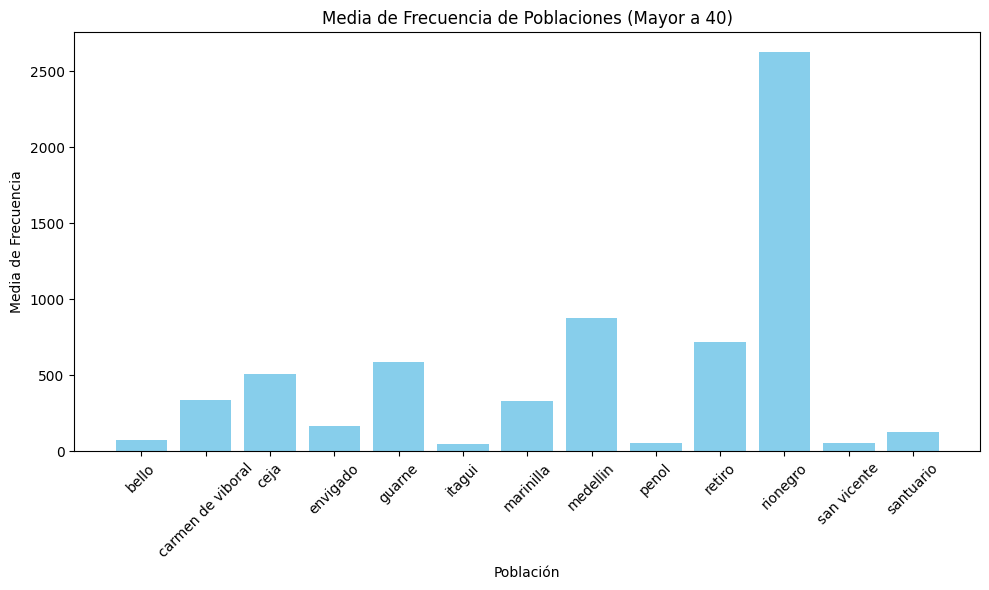

In [55]:
frecuencias = billing_records.groupby(['Semana', 'Población']).size().reset_index(name='Frecuencia')

media_frecuencia = frecuencias.groupby('Población')['Frecuencia'].mean().reset_index()

media_frecuencia = media_frecuencia.rename(columns={'Frecuencia': 'Media Frecuencia'})


media_frecuencia_filtrada = media_frecuencia[media_frecuencia['Media Frecuencia'] > 40]

plt.figure(figsize=(10, 6))
plt.bar(media_frecuencia_filtrada['Población'], media_frecuencia_filtrada['Media Frecuencia'], color='skyblue')
plt.title('Media de Frecuencia de Poblaciones (Mayor a 40)')
plt.xlabel('Población')
plt.ylabel('Media de Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
poblaciones_filtradas = media_frecuencia_filtrada['Población'].tolist() 

billing_records['Clasificación'] = billing_records['Población'].apply(lambda x: x if x in poblaciones_filtradas else 'Otro')

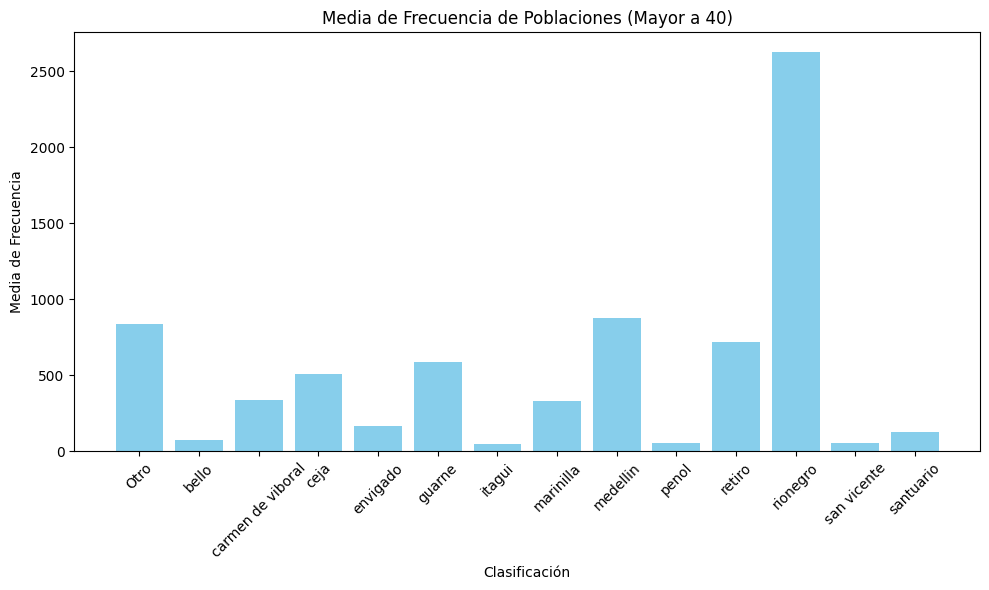

In [57]:
frecuencias = billing_records.groupby(['Semana', 'Clasificación']).size().reset_index(name='Frecuencia')

media_frecuencia = frecuencias.groupby('Clasificación')['Frecuencia'].mean().reset_index()

media_frecuencia = media_frecuencia.rename(columns={'Frecuencia': 'Media Frecuencia'})


media_frecuencia_filtrada = media_frecuencia[media_frecuencia['Media Frecuencia'] > 40]

plt.figure(figsize=(10, 6))
plt.bar(media_frecuencia_filtrada['Clasificación'], media_frecuencia_filtrada['Media Frecuencia'], color='skyblue')
plt.title('Media de Frecuencia de Poblaciones (Mayor a 40)')
plt.xlabel('Clasificación')
plt.ylabel('Media de Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como se puede ver, se aplicó una reducción de categorías en cuanto a población, esto debido a la gran diferencia en frecuencia que aparece de cada población. De esta manera se puede asegurar que la categoría nueva presente una frecuencia considerable para su respectivo análisis.

Vamos a hacer un análisis similar con respecto a la aseguradora

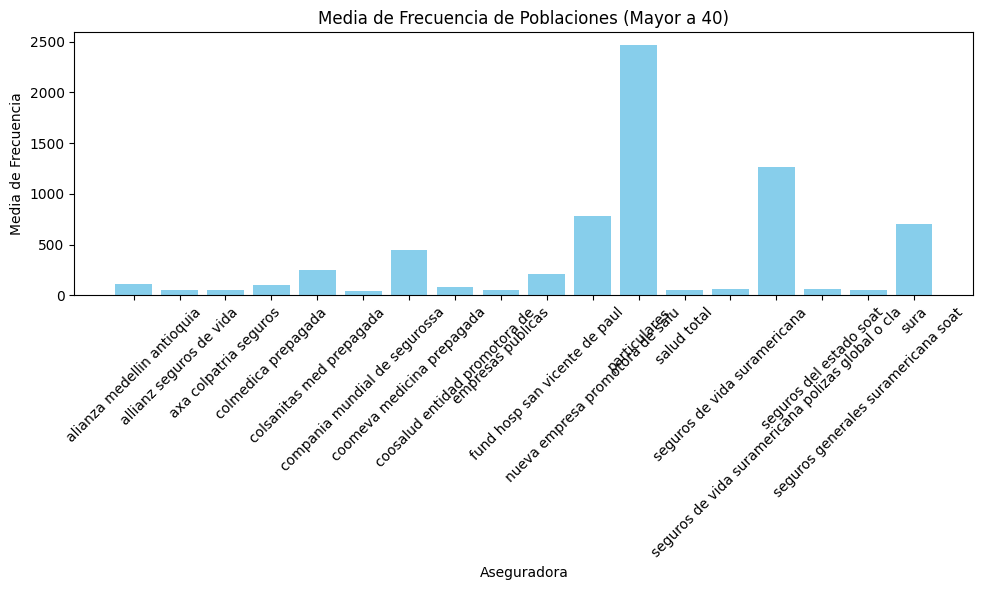

In [58]:
trsh = 40
frecuencias = billing_records.groupby(['Semana', 'Aseguradora']).size().reset_index(name='Frecuencia')

media_frecuencia = frecuencias.groupby('Aseguradora')['Frecuencia'].mean().reset_index()

media_frecuencia = media_frecuencia.rename(columns={'Frecuencia': 'Media Frecuencia'})


media_frecuencia_filtrada = media_frecuencia[media_frecuencia['Media Frecuencia'] > trsh]

plt.figure(figsize=(10, 6))
plt.bar(media_frecuencia_filtrada['Aseguradora'], media_frecuencia_filtrada['Media Frecuencia'], color='skyblue')
plt.title(f'Media de Frecuencia de Poblaciones (Mayor a {trsh})')
plt.xlabel('Aseguradora')
plt.ylabel('Media de Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
poblaciones_filtradas = media_frecuencia_filtrada['Aseguradora'].tolist() 

billing_records['Clasificación-aseguradora'] = billing_records['Aseguradora'].apply(lambda x: x if x in poblaciones_filtradas else 'Otro')

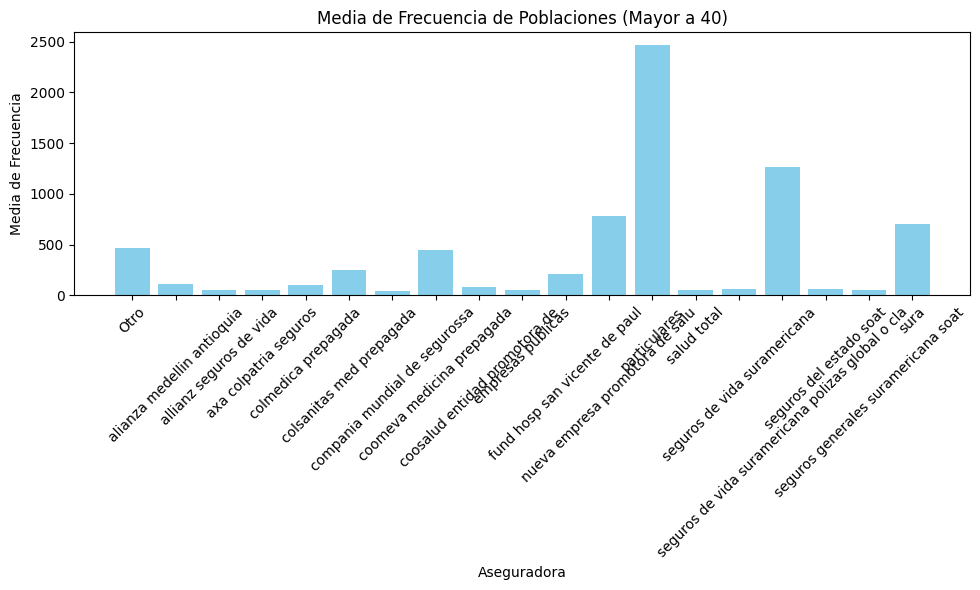

In [60]:
frecuencias = billing_records.groupby(['Semana', 'Clasificación-aseguradora']).size().reset_index(name='Frecuencia')

media_frecuencia = frecuencias.groupby('Clasificación-aseguradora')['Frecuencia'].mean().reset_index()

media_frecuencia = media_frecuencia.rename(columns={'Frecuencia': 'Media Frecuencia'})


media_frecuencia_filtrada = media_frecuencia[media_frecuencia['Media Frecuencia'] > trsh]

plt.figure(figsize=(10, 6))
plt.bar(media_frecuencia_filtrada['Clasificación-aseguradora'], media_frecuencia_filtrada['Media Frecuencia'], color='skyblue')
plt.title(f'Media de Frecuencia de Poblaciones (Mayor a {trsh})')
plt.xlabel('Aseguradora')
plt.ylabel('Media de Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
billing_records.columns

Index(['Valor neto', 'Creado el', 'Aseguradora', 'Clase episodio',
       'Centro de Responsabilidad', 'Género', 'Población', 'Edad', 'Semana',
       'Año', 'Mes', 'Clasificación', 'Clasificación-aseguradora'],
      dtype='object')

Las variables que hemos conseguido tienen una revelancia importante en el valor neto, puesto que lo justifican de alguna manera ya que estan altamente relacionados.

- Aseguradora: Vimos en el análisis que la aseguradora impacta en el valor neto y esto se puede deber a diferencias en tarifas entre una aseguradora y otra. 
- Clase episodio: Existen dos tipos de clase de episodio que se diferencian significativamente y que tienen impacto sobre el valor neto. Estos episodios pueden presentar patrones a lo largo del tiempo que influencian el valor neto.
- Centro de Responsabilidad: Se puede verificar que el centro de responsabilidad influye en el valor neto puesto que vimos diferencias en el valor neto para cada categoría por lo que es importante tenerlo en cuenta. 
- Género y edad: El genero y la edad son aspectos importantes a tener en cuenta para crear patrones de estacionalidad a nivel de tiempo.
- Población: Esta variable podría indicar una cierta relación del valor neto con respecto al lugar de donde proviene la población, puesto que podría dar indicios de influencias geográficas, culturales, entre otras. 



In [99]:
data = billing_records.copy()
data.head()

,Valor neto,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Semana,Año,Mes,Clasificación,Clasificación-aseguradora
0,238650.0,2022-01-01,seguros de vida suramericana poliza juvenilaccid,ambulatorio,530101,M,retiro,14.0,52,2022,1,retiro,Otro
1,142500.0,2022-01-01,particulares,ambulatorio,530101,M,bogota,51.0,52,2022,1,Otro,particulares
2,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,41.0,52,2022,1,rionegro,particulares
3,142500.0,2022-01-01,particulares,ambulatorio,530101,M,medellin,31.0,52,2022,1,medellin,particulares
4,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,38.0,52,2022,1,rionegro,particulares


In [100]:
data = pd.concat([data, pd.get_dummies(data['Clasificación'], prefix='Poblacion')], axis=1)
data.head()


,Valor neto,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Semana,Año,...,Poblacion_envigado,Poblacion_guarne,Poblacion_itagui,Poblacion_marinilla,Poblacion_medellin,Poblacion_penol,Poblacion_retiro,Poblacion_rionegro,Poblacion_san vicente,Poblacion_santuario
0,238650.0,2022-01-01,seguros de vida suramericana poliza juvenilaccid,ambulatorio,530101,M,retiro,14.0,52,2022,...,False,False,False,False,False,False,True,False,False,False
1,142500.0,2022-01-01,particulares,ambulatorio,530101,M,bogota,51.0,52,2022,...,False,False,False,False,False,False,False,False,False,False
2,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,41.0,52,2022,...,False,False,False,False,False,False,False,True,False,False
3,142500.0,2022-01-01,particulares,ambulatorio,530101,M,medellin,31.0,52,2022,...,False,False,False,False,True,False,False,False,False,False
4,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,38.0,52,2022,...,False,False,False,False,False,False,False,True,False,False


In [101]:
data = pd.concat([data, pd.get_dummies(data['Clasificación-aseguradora'], prefix='Aseguradora')], axis=1)
data.head()

,Valor neto,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Semana,Año,...,Aseguradora_empresas publicas,Aseguradora_fund hosp san vicente de paul,Aseguradora_nueva empresa promotora de salu,Aseguradora_particulares,Aseguradora_salud total,Aseguradora_seguros de vida suramericana,Aseguradora_seguros de vida suramericana polizas global o cla,Aseguradora_seguros del estado soat,Aseguradora_seguros generales suramericana soat,Aseguradora_sura
0,238650.0,2022-01-01,seguros de vida suramericana poliza juvenilaccid,ambulatorio,530101,M,retiro,14.0,52,2022,...,False,False,False,False,False,False,False,False,False,False
1,142500.0,2022-01-01,particulares,ambulatorio,530101,M,bogota,51.0,52,2022,...,False,False,False,True,False,False,False,False,False,False
2,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,41.0,52,2022,...,False,False,False,True,False,False,False,False,False,False
3,142500.0,2022-01-01,particulares,ambulatorio,530101,M,medellin,31.0,52,2022,...,False,False,False,True,False,False,False,False,False,False
4,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,38.0,52,2022,...,False,False,False,True,False,False,False,False,False,False


In [102]:
data = pd.concat([data, pd.get_dummies(data['Género'], prefix='Genero')], axis=1)
data.head()

,Valor neto,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Semana,Año,...,Aseguradora_nueva empresa promotora de salu,Aseguradora_particulares,Aseguradora_salud total,Aseguradora_seguros de vida suramericana,Aseguradora_seguros de vida suramericana polizas global o cla,Aseguradora_seguros del estado soat,Aseguradora_seguros generales suramericana soat,Aseguradora_sura,Genero_F,Genero_M
0,238650.0,2022-01-01,seguros de vida suramericana poliza juvenilaccid,ambulatorio,530101,M,retiro,14.0,52,2022,...,False,False,False,False,False,False,False,False,False,True
1,142500.0,2022-01-01,particulares,ambulatorio,530101,M,bogota,51.0,52,2022,...,False,True,False,False,False,False,False,False,False,True
2,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,41.0,52,2022,...,False,True,False,False,False,False,False,False,False,True
3,142500.0,2022-01-01,particulares,ambulatorio,530101,M,medellin,31.0,52,2022,...,False,True,False,False,False,False,False,False,False,True
4,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,38.0,52,2022,...,False,True,False,False,False,False,False,False,False,True


In [103]:
data = pd.concat([data, pd.get_dummies(data['Centro de Responsabilidad'], prefix='centro')], axis=1)
data.head()

,Valor neto,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Semana,Año,...,Genero_M,centro_530101,centro_530201,centro_530301,centro_530401,centro_530718,centro_530801,centro_530809,centro_530812,centro_530815
0,238650.0,2022-01-01,seguros de vida suramericana poliza juvenilaccid,ambulatorio,530101,M,retiro,14.0,52,2022,...,True,True,False,False,False,False,False,False,False,False
1,142500.0,2022-01-01,particulares,ambulatorio,530101,M,bogota,51.0,52,2022,...,True,True,False,False,False,False,False,False,False,False
2,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,41.0,52,2022,...,True,True,False,False,False,False,False,False,False,False
3,142500.0,2022-01-01,particulares,ambulatorio,530101,M,medellin,31.0,52,2022,...,True,True,False,False,False,False,False,False,False,False
4,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,38.0,52,2022,...,True,True,False,False,False,False,False,False,False,False


In [104]:
data = pd.concat([data, pd.get_dummies(data['Clase episodio'], prefix='Episodio')], axis=1)
data.head()

,Valor neto,Creado el,Aseguradora,Clase episodio,Centro de Responsabilidad,Género,Población,Edad,Semana,Año,...,centro_530201,centro_530301,centro_530401,centro_530718,centro_530801,centro_530809,centro_530812,centro_530815,Episodio_ambulatorio,Episodio_hospitalizado
0,238650.0,2022-01-01,seguros de vida suramericana poliza juvenilaccid,ambulatorio,530101,M,retiro,14.0,52,2022,...,False,False,False,False,False,False,False,False,True,False
1,142500.0,2022-01-01,particulares,ambulatorio,530101,M,bogota,51.0,52,2022,...,False,False,False,False,False,False,False,False,True,False
2,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,41.0,52,2022,...,False,False,False,False,False,False,False,False,True,False
3,142500.0,2022-01-01,particulares,ambulatorio,530101,M,medellin,31.0,52,2022,...,False,False,False,False,False,False,False,False,True,False
4,142500.0,2022-01-01,particulares,ambulatorio,530101,M,rionegro,38.0,52,2022,...,False,False,False,False,False,False,False,False,True,False


In [105]:
data.columns

Index(['Valor neto', 'Creado el', 'Aseguradora', 'Clase episodio',
       'Centro de Responsabilidad', 'Género', 'Población', 'Edad', 'Semana',
       'Año', 'Mes', 'Clasificación', 'Clasificación-aseguradora',
       'Poblacion_Otro', 'Poblacion_bello', 'Poblacion_carmen de viboral',
       'Poblacion_ceja', 'Poblacion_envigado', 'Poblacion_guarne',
       'Poblacion_itagui', 'Poblacion_marinilla', 'Poblacion_medellin',
       'Poblacion_penol', 'Poblacion_retiro', 'Poblacion_rionegro',
       'Poblacion_san vicente', 'Poblacion_santuario', 'Aseguradora_Otro',
       'Aseguradora_alianza medellin antioquia',
       'Aseguradora_allianz seguros de vida',
       'Aseguradora_axa colpatria seguros', 'Aseguradora_colmedica prepagada',
       'Aseguradora_colsanitas med prepagada',
       'Aseguradora_compania mundial de segurossa',
       'Aseguradora_coomeva medicina prepagada',
       'Aseguradora_coosalud entidad promotora de',
       'Aseguradora_empresas publicas',
       'Asegurador

In [106]:
data = data.drop(columns=['Aseguradora', 'Clase episodio','Centro de Responsabilidad', 'Género', 'Población', 'Año', 'Mes', 'Semana', 'Clasificación', 'Clasificación-aseguradora'])
data.columns

Index(['Valor neto', 'Creado el', 'Edad', 'Poblacion_Otro', 'Poblacion_bello',
       'Poblacion_carmen de viboral', 'Poblacion_ceja', 'Poblacion_envigado',
       'Poblacion_guarne', 'Poblacion_itagui', 'Poblacion_marinilla',
       'Poblacion_medellin', 'Poblacion_penol', 'Poblacion_retiro',
       'Poblacion_rionegro', 'Poblacion_san vicente', 'Poblacion_santuario',
       'Aseguradora_Otro', 'Aseguradora_alianza medellin antioquia',
       'Aseguradora_allianz seguros de vida',
       'Aseguradora_axa colpatria seguros', 'Aseguradora_colmedica prepagada',
       'Aseguradora_colsanitas med prepagada',
       'Aseguradora_compania mundial de segurossa',
       'Aseguradora_coomeva medicina prepagada',
       'Aseguradora_coosalud entidad promotora de',
       'Aseguradora_empresas publicas',
       'Aseguradora_fund hosp san vicente de paul',
       'Aseguradora_nueva empresa promotora de salu',
       'Aseguradora_particulares', 'Aseguradora_salud total',
       'Aseguradora_seguro

In [107]:
data.set_index('Creado el', inplace=True)
data.head()

,Valor neto,Edad,Poblacion_Otro,Poblacion_bello,Poblacion_carmen de viboral,Poblacion_ceja,Poblacion_envigado,Poblacion_guarne,Poblacion_itagui,Poblacion_marinilla,...,centro_530201,centro_530301,centro_530401,centro_530718,centro_530801,centro_530809,centro_530812,centro_530815,Episodio_ambulatorio,Episodio_hospitalizado
Creado el,,,,,,,,,,,,,,,,,,,,,
2022-01-01,238650.0,14.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-01-01,142500.0,51.0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-01-01,142500.0,41.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-01-01,142500.0,31.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-01-01,142500.0,38.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [108]:
data_week = data.resample('W').agg({
    'Valor neto': 'sum',
    'Edad': 'mean',
    'Poblacion_Otro':'sum', 
    'Poblacion_bello':'sum',
    'Poblacion_carmen de viboral':'sum', 
    'Poblacion_ceja':'sum', 
    'Poblacion_envigado':'sum',
    'Poblacion_guarne':'sum', 
    'Poblacion_itagui':'sum', 
    'Poblacion_marinilla':'sum',
    'Poblacion_medellin':'sum', 
    'Poblacion_penol':'sum', 
    'Poblacion_retiro':'sum',
    'Poblacion_rionegro':'sum', 
    'Poblacion_san vicente':'sum', 
    'Poblacion_santuario':'sum',
    'Aseguradora_Otro':'sum', 
    'Aseguradora_alianza medellin antioquia':'sum',
    'Aseguradora_allianz seguros de vida':'sum',
    'Aseguradora_axa colpatria seguros':'sum', 
    'Aseguradora_colmedica prepagada':'sum',
    'Aseguradora_colsanitas med prepagada':'sum',
    'Aseguradora_compania mundial de segurossa':'sum',
    'Aseguradora_coomeva medicina prepagada':'sum',
    'Aseguradora_coosalud entidad promotora de':'sum',
    'Aseguradora_empresas publicas':'sum',
    'Aseguradora_fund hosp san vicente de paul':'sum',
    'Aseguradora_nueva empresa promotora de salu':'sum',
    'Aseguradora_particulares':'sum', 
    'Aseguradora_salud total':'sum',
    'Aseguradora_seguros de vida suramericana':'sum',
    'Aseguradora_seguros de vida suramericana polizas global o cla':'sum',
    'Aseguradora_seguros del estado soat':'sum',
    'Aseguradora_seguros generales suramericana soat':'sum', 
    'Aseguradora_sura':'sum',
    'Genero_F':'sum', 
    'Genero_M':'sum', 
    'centro_530101':'sum', 
    'centro_530201':'sum',
    'centro_530301':'sum', 
    'centro_530401':'sum', 
    'centro_530718':'sum', 
    'centro_530801':'sum',
    'centro_530809':'sum', 
    'centro_530812':'sum', 
    'centro_530815':'sum',
    'Episodio_ambulatorio':'sum', 
    'Episodio_hospitalizado':'sum',
})

In [110]:
data_week['Edad'] = data_week['Edad'].astype(int)

In [111]:
data_week.head()

,Valor neto,Edad,Poblacion_Otro,Poblacion_bello,Poblacion_carmen de viboral,Poblacion_ceja,Poblacion_envigado,Poblacion_guarne,Poblacion_itagui,Poblacion_marinilla,...,centro_530201,centro_530301,centro_530401,centro_530718,centro_530801,centro_530809,centro_530812,centro_530815,Episodio_ambulatorio,Episodio_hospitalizado
Creado el,,,,,,,,,,,,,,,,,,,,,
2022-01-02,5.147270e+08,38,58,3,5,9,31,31,2,8,...,78,0,0,33,0,0,0,0,448,36
2022-01-09,3.312785e+09,47,279,48,155,239,82,269,38,166,...,406,333,263,479,627,280,0,99,3160,254
2022-01-16,3.480253e+09,48,321,30,129,170,65,230,25,148,...,276,500,228,460,464,131,90,39,2685,248
2022-01-23,4.208028e+09,50,380,50,143,205,68,216,34,165,...,393,585,299,528,407,214,199,20,3062,287
2022-01-30,4.711394e+09,50,465,26,151,196,72,270,24,172,...,549,494,301,540,375,308,2,68,2959,301


In [ ]:
columns = data_week.columns
for column in columns:
    if column in ['Valor neto', 'Edad']:
        continue
    data_week[f'Freq_{column}'] = data_week[column].rolling(window=4, min_periods=1).mean()

In [178]:
columns = data_week.columns
columns_2_delete = []
for column in columns:
    if column in ['Valor neto', 'Edad'] or column.startswith('Freq_'):
        continue
    columns_2_delete.append(column)

data_week = data_week.drop(columns=columns_2_delete)

In [195]:
data_week['Mes'] = data_week.index.month
data_week = pd.get_dummies(data_week, columns=['Mes'])
data_week.head()

,Valor neto,Edad,Freq_Poblacion_Otro,Freq_Poblacion_bello,Freq_Poblacion_carmen de viboral,Freq_Poblacion_ceja,Freq_Poblacion_envigado,Freq_Poblacion_guarne,Freq_Poblacion_itagui,Freq_Poblacion_marinilla,...,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12
Creado el,,,,,,,,,,,,,,,,,,,,,
2022-01-02,5.147270e+08,38,58.000000,3.00,5.000000,9.000000,31.000000,31.000000,2.000000,8.000000,...,False,False,False,False,False,False,False,False,False,False
2022-01-09,3.312785e+09,47,168.500000,25.50,80.000000,124.000000,56.500000,150.000000,20.000000,87.000000,...,False,False,False,False,False,False,False,False,False,False
2022-01-16,3.480253e+09,48,219.333333,27.00,96.333333,139.333333,59.333333,176.666667,21.666667,107.333333,...,False,False,False,False,False,False,False,False,False,False
2022-01-23,4.208028e+09,50,259.500000,32.75,108.000000,155.750000,61.500000,186.500000,24.750000,121.750000,...,False,False,False,False,False,False,False,False,False,False
2022-01-30,4.711394e+09,50,361.250000,38.50,144.500000,202.500000,71.750000,246.250000,30.250000,162.750000,...,False,False,False,False,False,False,False,False,False,False


In [373]:
data_week['Semana'] =data_week.index.isocalendar().week

Las colmunas de freq guardan un valor de ventana de maximo 4 semanas atrás. Esto funciona como un promedio móvil que indica como se mueve la variable en el tiempo. Esto se hace para complementar el modelo de serie temporal que se planea crear para tener en cuenta el comportamiento de estas variables ya que en un entorno de producción no se tienen los valores de estas variables pero si se puede conocer los valores pasados.

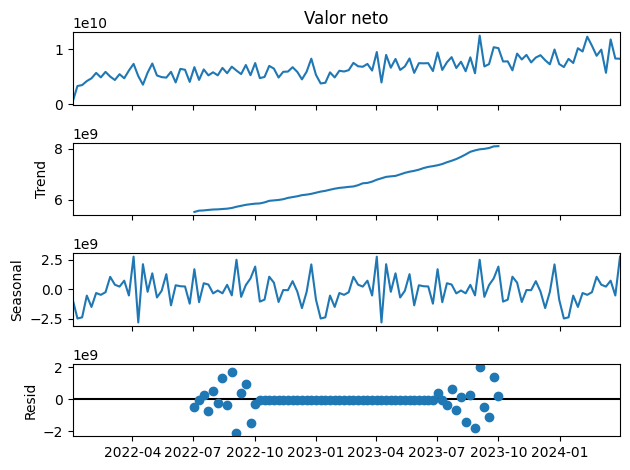

In [374]:
decomposition = seasonal_decompose(data_week['Valor neto'], model='additive')  
decomposition.plot()
plt.show()

En las graficas anteriores ponemos ver que en la gráfica "Seasonal" existen patrones que se repiten, esto podría indicar estacionariedad. Por otro lado, la grafica de tendencia indica un crecimiento a lo largo del tiempo y la gráfica de residuo indica un ruido un poco menos aleatorio pero que no descarta la estacionariedad.

Vamos a crear un modelo SARIMAX que permite la inclusión de variables exógenas asi como el modelo de serie temporal y vamos a verificar los resultados. 

In [375]:
columns_bool = data_week.select_dtypes(exclude=[float]).columns
for column in columns_bool:
    data_week[column] = data_week[column].astype(int)
    
data_week.head()

,Valor neto,Edad,Freq_Poblacion_Otro,Freq_Poblacion_bello,Freq_Poblacion_carmen de viboral,Freq_Poblacion_ceja,Freq_Poblacion_envigado,Freq_Poblacion_guarne,Freq_Poblacion_itagui,Freq_Poblacion_marinilla,...,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12,Semana
Creado el,,,,,,,,,,,,,,,,,,,,,
2022-01-02,5.147270e+08,38,58.000000,3.00,5.000000,9.000000,31.000000,31.000000,2.000000,8.000000,...,0,0,0,0,0,0,0,0,0,52
2022-01-09,3.312785e+09,47,168.500000,25.50,80.000000,124.000000,56.500000,150.000000,20.000000,87.000000,...,0,0,0,0,0,0,0,0,0,1
2022-01-16,3.480253e+09,48,219.333333,27.00,96.333333,139.333333,59.333333,176.666667,21.666667,107.333333,...,0,0,0,0,0,0,0,0,0,2
2022-01-23,4.208028e+09,50,259.500000,32.75,108.000000,155.750000,61.500000,186.500000,24.750000,121.750000,...,0,0,0,0,0,0,0,0,0,3
2022-01-30,4.711394e+09,50,361.250000,38.50,144.500000,202.500000,71.750000,246.250000,30.250000,162.750000,...,0,0,0,0,0,0,0,0,0,4


In [413]:
train_size = int(len(data_week) * 0.95)
train, test = data_week.iloc[:train_size], data_week.iloc[train_size:]

In [414]:
y_train = train['Valor neto']
X_train = train.drop(columns=['Valor neto'])

y_test = test['Valor neto']
X_test = test.drop(columns=['Valor neto'])

In [415]:
X_train.head()

,Edad,Freq_Poblacion_Otro,Freq_Poblacion_bello,Freq_Poblacion_carmen de viboral,Freq_Poblacion_ceja,Freq_Poblacion_envigado,Freq_Poblacion_guarne,Freq_Poblacion_itagui,Freq_Poblacion_marinilla,Freq_Poblacion_medellin,...,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12,Semana
Creado el,,,,,,,,,,,,,,,,,,,,,
2022-01-02,38,58.000000,3.00,5.000000,9.000000,31.000000,31.000000,2.000000,8.000000,154.000000,...,0,0,0,0,0,0,0,0,0,52
2022-01-09,47,168.500000,25.50,80.000000,124.000000,56.500000,150.000000,20.000000,87.000000,365.500000,...,0,0,0,0,0,0,0,0,0,1
2022-01-16,48,219.333333,27.00,96.333333,139.333333,59.333333,176.666667,21.666667,107.333333,374.666667,...,0,0,0,0,0,0,0,0,0,2
2022-01-23,50,259.500000,32.75,108.000000,155.750000,61.500000,186.500000,24.750000,121.750000,393.750000,...,0,0,0,0,0,0,0,0,0,3
2022-01-30,50,361.250000,38.50,144.500000,202.500000,71.750000,246.250000,30.250000,162.750000,468.750000,...,0,0,0,0,0,0,0,0,0,4


In [416]:
model = SARIMAX(y_train, exog=X_train, order=(1, 1,2), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit(disp=False)

/Users/carlosmunoz/Desktop/SV_CarlosMunoz/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/carlosmunoz/Desktop/SV_CarlosMunoz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


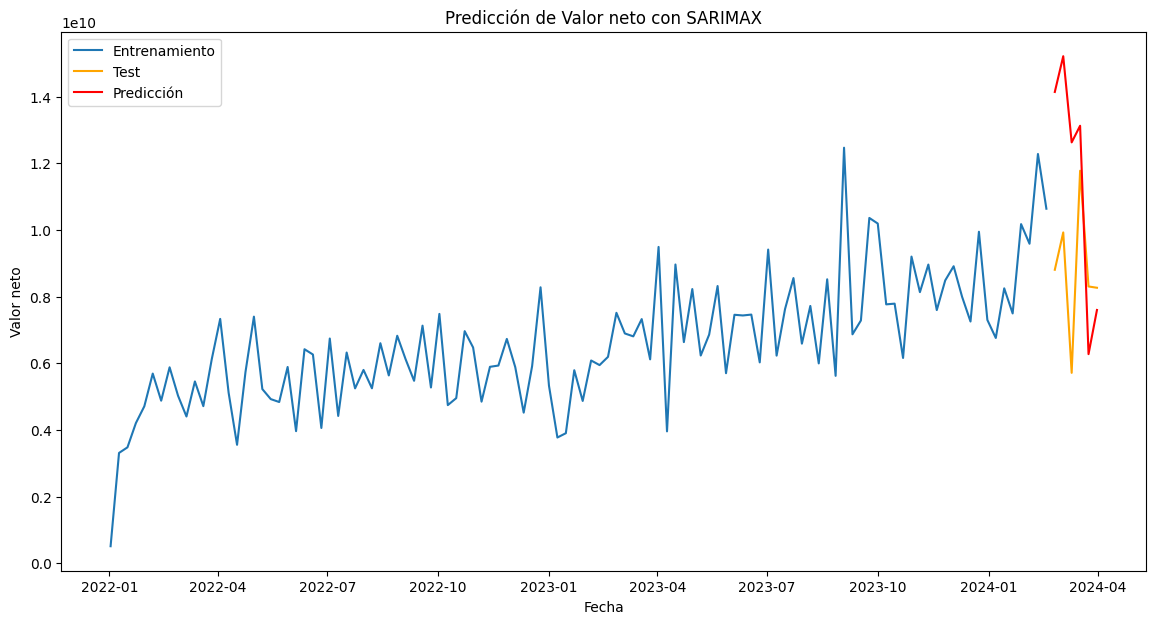

In [417]:
forecast = model_fit.get_forecast(steps=len(y_test), exog=X_test)  # Usamos el conjunto de prueba
forecast_mean = forecast.predicted_mean

# Visualizar resultados
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Entrenamiento')
plt.plot(test.index, y_test, label='Test', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Valor neto')
plt.title('Predicción de Valor neto con SARIMAX')
plt.legend()
plt.show()

In [418]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_test, forecast_mean)
print(f'RMSE: {rmse}')
max_valor_neto = y_test.max()
min_valor_neto = y_test.min()

print(f'Valor neto máximo: {max_valor_neto}')
print(f'Valor neto mínimo: {min_valor_neto}')

RMSE: 4292386368.465562
Valor neto máximo: 11777279640.0
Valor neto mínimo: 5714713783.5


Ahora vamos a crear un modelo ARIMA para verificar como se puede comportar solo tomando la serie temporal

In [382]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(8, 1, 1))
model_fit = model.fit()

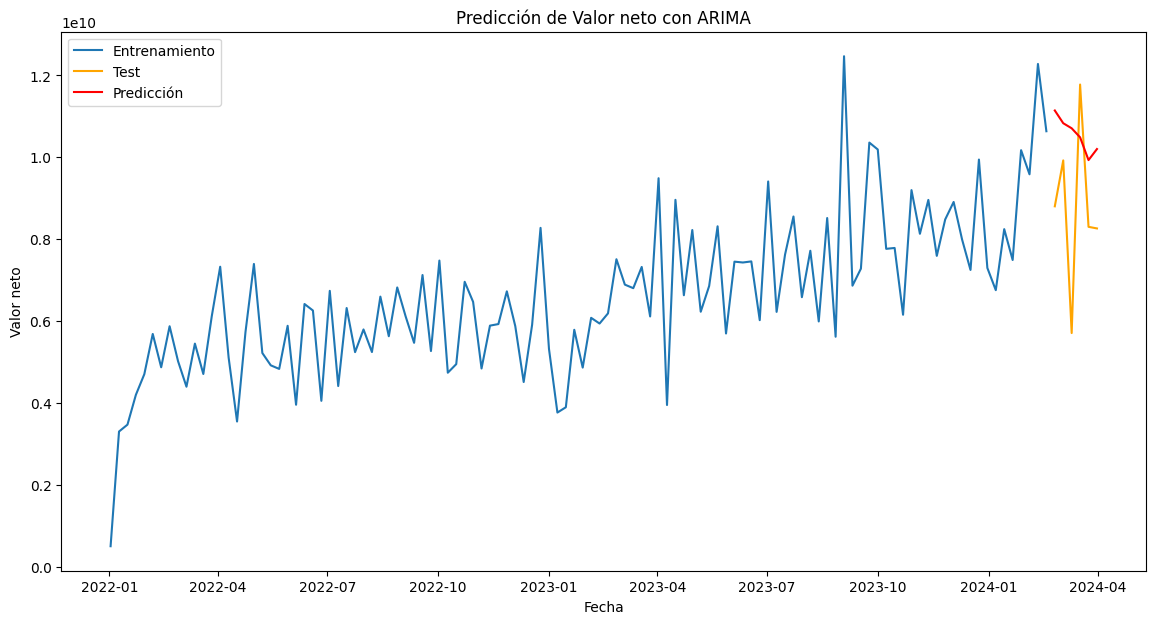

In [383]:
forecast = model_fit.get_forecast(steps=len(y_test), exog=X_test)  # Usamos el conjunto de prueba
forecast_mean = forecast.predicted_mean

# Visualizar resultados
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Entrenamiento')
plt.plot(test.index, y_test, label='Test', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Valor neto')
plt.title('Predicción de Valor neto con ARIMA')
plt.legend()
plt.show()

In [384]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_test, forecast_mean)
print(f'RMSE: {rmse}')
max_valor_neto = y_test.max()
min_valor_neto = y_test.min()

print(f'Valor neto máximo: {max_valor_neto}')
print(f'Valor neto mínimo: {min_valor_neto}')

RMSE: 2559241209.6170335
Valor neto máximo: 11777279640.0
Valor neto mínimo: 5714713783.5


Estos modelos tienen un valor de error bastante alto que no podría ser aceptable. También es valido decir que no tiene bastantes datos por lo que vamos a verificar otro modelo.

In [392]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=8, learning_rate=0.05, reg_alpha=0.5, reg_lambda=1, gamma=0.1)
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [393]:
y_pred = best_model.predict(X_test)

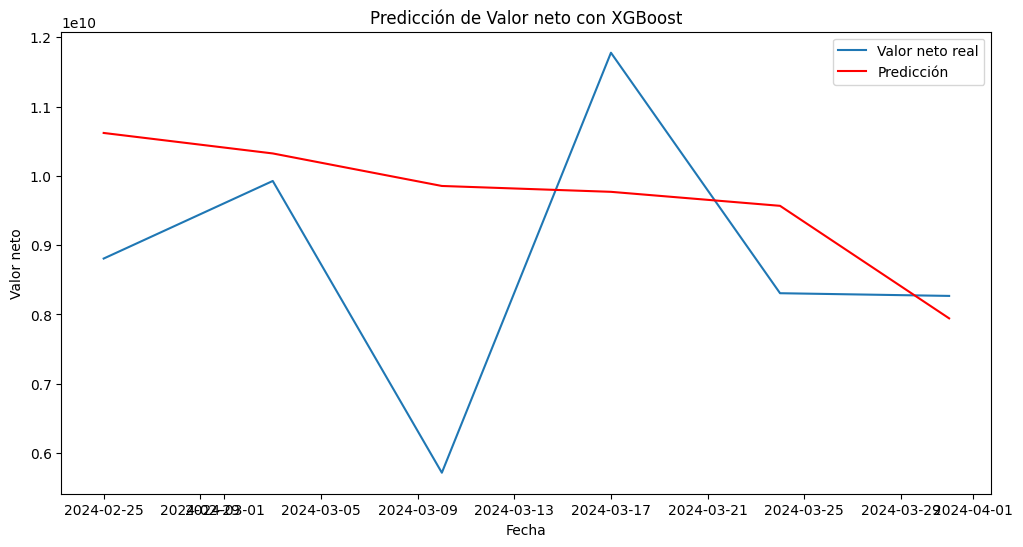

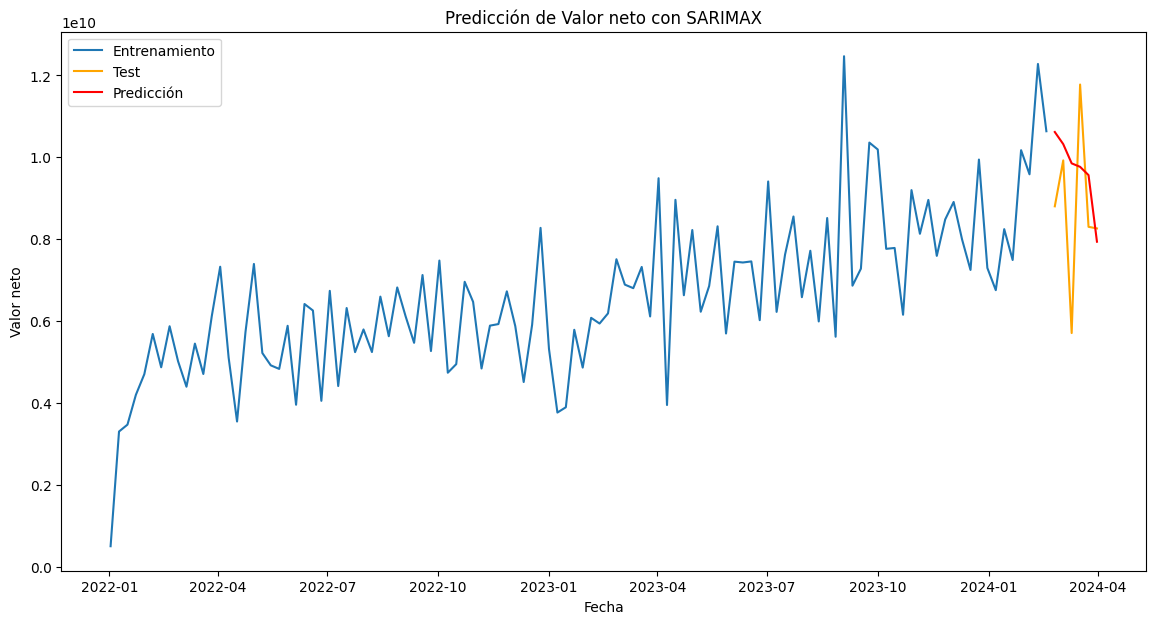

In [394]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valor neto real')
plt.plot(y_test.index, y_pred, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Valor neto')
plt.title('Predicción de Valor neto con XGBoost')
plt.legend()
plt.show()


# Visualizar resultados
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Entrenamiento')
plt.plot(y_test.index, y_test, label='Test', color='orange')
plt.plot(y_test.index, y_pred, label='Predicción', color='red')
plt.xlabel('Fecha')
plt.ylabel('Valor neto')
plt.title('Predicción de Valor neto con SARIMAX')
plt.legend()
plt.show()

In [395]:
from sklearn.metrics import root_mean_squared_error
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
print(f'Valor neto máximo: {max_valor_neto}')
print(f'Valor neto mínimo: {min_valor_neto}')

RMSE: 45758.798773703376
Valor neto máximo: 11777279640.0
Valor neto mínimo: 5714713783.5


In [396]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

MAE: 1657134527.0833333


In [397]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')

R²: -0.3035672584436271


In [ ]:
model_name = 'predictor_xgboost.json'
best_model.save_model(f'{config.MODEL_ROOT_PATH}/{model_name}')

In [422]:
params = best_model.get_params()
print(params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 400, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.5, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


## Consideraciones y análisis final.


La predicción del valor neto semanalmente es un problema que necesita bastante información para poder encontrar patrones estacionales a lo largo del tiempo. En este caso, se hizo uso de otras variables que pudieran servir como insumos al modelo para poder predecir de mejor manera el valor neto de forma semanal en el hospital. Las variables asociadas al centro de responsabilidad, población, género, edad y demás son variables que se pensaba tratar de una manera especial cada una debido a su naturaleza categórica.


El enfoque que se buscó para que el modelo pudiera generalizar semanalmente es poder encontrar aquellas categorías en cada variable que tienen mayor frecuencia por semana. De esta manera, se busca hacer una reducción de dimensionalidad, eliminando aquellas que no contienen suficientes registros para ser estadísticamente relevantes y se las clasifica en una nueva categoría denominada "otros". Esta estrategía se hace para que aquellos patrones asociados a la composición de las diferentes categorías semana a semana no pierdan su importancia. Después, se busca hacer una sumatoria de frecuencias, puesto que la base de datos que fue suministrada contiene datos por día y con las frecuencias semanales se puede encontrar la composición semana a semana.


Finalmente, se probaron modelos SARIMAX y ARIMA que son modelos que permiten el manejo de series temporales. Por su parte, SARIMAX es un modelo que permite introducir variables exógenas como las que tenemos en nuestro caso que podrían dar una explicación a la variable objetivo, el valor neto. Por otro lado, el modelo ARIMA es un modelo neto de serie temporal que busca predecir la variable como tal sin incluir variables externas. Finalmente, se usa un modelo XGBoost de regresión en el cual se hace una búsqueda de los mejores parámetros de predicción. En los resultados sobre el RSME se puede ver una mejora muy considerable, pero las otras dos métricas de error indican que el modelo no es capaz de predecir de la mejor manera.


Considero que estos resultados se deben a la falta de datos para obtener una estacionariedad en las semanas e incluso que el modelo pueda generalizar de una mejor manera la predicción de los datos. Sin embargo, es válido rescatar que se puede realizar una investigación más profunda a los datos y poder investigar nuevas estrategías e ingeniería de datos para poder comparar con los resultados obtenidos.